# Algorithms in Qiskit Core

1. [Grover](#grover)
1. [Amplitude estimation](#ae)
1. [Minimum eigenvalues](#mes)
1. [(General) Eigenvalues](#es)
1. [Shor](#shor)
1. [HHL](#hhl)
1. [Phase Estimation](#pe)

## Algorithms structure

![algorithms flow](algorithmflow.png)

Setting the quantum instance/backend for this notebook:

In [1]:
from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('qasm_simulator')
qinstance = QuantumInstance(backend, shots=1024)

## Grover<a href='#' id='grover'></a>

The algorithm instance is decoupled from the problem it solves. This means one instance of `Grover` can be re-used to find good states in several oracles.

In [2]:
from qiskit.algorithms import Grover

grover = Grover(quantum_instance=qinstance)

Here's the oracle (as a plain `QuantumCircuit`) and a classical function to identify good states.

In [3]:
from qiskit.circuit import QuantumCircuit

oracle = QuantumCircuit(2)
oracle.cz(0, 1)

def is_good_state(bitstr):
    return sum(map(int, bitstr)) == 2

The problem, in this case the oracle and identification of a "good" state, is wrapped in an `AmplificationProblem`.

In [4]:
from qiskit.algorithms import AmplificationProblem

problem = AmplificationProblem(oracle=oracle, is_good_state=is_good_state)

Running the algorithm returns a `GroverResult`:

In [5]:
result = grover.amplify(problem)
print('Top bitstring:', result.top_measurement)
print('Good state?', result.oracle_evaluation)

Top bitstring: 11
Good state? True


## Amplitude estimation<a href='#' id='ae'></a>

Algorithms have interfaces. All algorithms implementing the same interface can solve the same problem. In amplitude estimation, we have 
* `AmplitudeEstimation`
* `IterativeAmplitudeEstimation`
* `MaximumLikelihoodAmplitudeEstimation`, and
* `FasterAmplitudeEstimation`

that can exchangeably be used to solve an `EstimationProblem`.

Here, we'd like to estimate the probability of measuring a $|1\rangle$ in our single qubit.

In [6]:
import numpy as np

probability = 0.25
rotation_angle = 2 * np.sqrt(np.arcsin(probability))

state_preparation = QuantumCircuit(1)
state_preparation.ry(rotation_angle, 0)

objective_qubits = [0]  # the good states are identified by qubit 0 being in state |1>

print('Target probability:', probability)

Target probability: 0.25


The problem is wrapped in an `EstimationProblem`.

In [7]:
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=objective_qubits)

Now we can solve it with different amplitude estimation algorithms.

In [8]:
from qiskit.algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(num_eval_qubits=3, quantum_instance=qinstance)
result = ae.estimate(problem)
print('Grid-based estimate:', result.estimation) 
print('Improved continuous estimate:', result.mle)

Grid-based estimate: 0.1464466
Improved continuous estimate: 0.2364509484624398


In [9]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(epsilon_target=0.01, alpha=0.05, quantum_instance=qinstance)
result = iae.estimate(problem)
print('Estimate:', result.estimation)

Estimate: 0.2303591705802828


Similarly, we can also use `MaximumLikelihoodAmplitudeEstimation` and `FasterAmplitudeEstimation`.

## Minimum eigenvalues<a href='#' id='mes'></a>

All `MinimumEigensolver` algorithms implement a `compute_minimum_eigenvalue` method, that takes an observable and return the minimum eigenvalue. These algorithms can be quantum (VQE) or completely classically (NumPy-based).

In [10]:
from qiskit.opflow import Z, I

observable = Z ^ I 

### VQE

VQE takes an ansatz (here from the circuit library) and an optimizer.

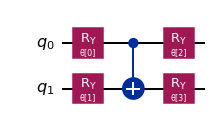

In [11]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(2, reps=1)

ansatz.draw(output='mpl', style='iqx')

In [12]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA

vqe = VQE(ansatz, optimizer=SPSA(), quantum_instance=qinstance)

Now we can solve the problem:

In [13]:
result = vqe.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

-1.0


### NumPy-based

Let's verify the result with a classical algorithm.

In [14]:
from qiskit.algorithms import NumPyMinimumEigensolver

np_mes = NumPyMinimumEigensolver()
result = np_mes.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-1+0j)


### QAOA

For Hamiltonians from combinatorial optimization (like ours: $Z \otimes I$) we can use the QAOA algorithm.

In [15]:
from qiskit.algorithms import QAOA

qaoa = QAOA(optimizer=SPSA(), quantum_instance=qinstance)
result = qaoa.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

-1.0


## (General) Eigenvalues <a href='#' id='es'></a>

Currently, only NumPy-based calculations are available, but more algorithms will be available in the chemistry package.

In [16]:
from qiskit.algorithms import NumPyEigensolver

np_mes = NumPyEigensolver(k=3)  # get the lowest 3 eigenvalues
result = np_mes.compute_eigenvalues(observable)
print(result.eigenvalues)

[-1.+0.j -1.+0.j  1.+0.j]


## Shor's algorithm<a href='#' id='shor'></a>

Shor's algorithm is currently the only factorization algorithm in Qiskit.

In [17]:
from qiskit.algorithms import Shor

shor = Shor(quantum_instance=qinstance)

Assume we want to factor the number 15.

In [18]:
N = 15
a = 2  # ``a`` is a number with greater than 1 with gcd(N, a) = 1

result = shor.factor(N, a)
print('Factors:', result.factors)

Factors: [[3, 5]]


## HHL<a href='#' id='hhl'></a>

_Pending pull request: [#5698](https://github.com/Qiskit/qiskit-terra/pull/5698)_

## Phase estimation<a href='#' id='pe'></a>

_Pending pull request: [#5642](https://github.com/Qiskit/qiskit-terra/pull/5642) (canonical & iterative)_